In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
import numerics
import cdd
import torch
from importlib import reload
import style
from os.path import join
#from sklearn.manifold import TSNE
import convex
reload(numerics)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])


In [11]:
def run_analysis():
    P_vals = np.arange(5, 8)
    max_n = np.max(P_vals)*(np.max(P_vals)-1)//2
    num_runs = 10000
    masks = np.zeros((len(P_vals), num_runs, max_n))
    params = np.zeros((len(P_vals), num_runs, np.max(P_vals)))
    num_vertices = np.zeros((len(P_vals), num_runs))
    for P_idx in range(len(P_vals)):
        P = P_vals[P_idx]
        n = P*(P-1)//2
        for run_idx in range(num_runs):
            if run_idx % 100 == 0:
                print(P, run_idx)
            success, vertices = False, []
            while not success or len(vertices) == 0:
                prms = np.sort(np.random.uniform(1., 3., size=(P,)))
                mask_nz, mask_z, vertices, success = convex.compute_vertices(prms)
            masks[P_idx, run_idx, :n] = mask_nz
            num_vertices[P_idx, run_idx] = len(vertices)
            params[P_idx, run_idx, :P] = prms
    np.savez(
        "convex_data_2_1_2024.npz", masks=masks, params=params,
        num_vertices=num_vertices, num_runs=num_runs,
        P_vals=P_vals)
    
#run_analysis()

data = np.load("convex_data_2_1_2024.npz")
masks, params, num_vertices, num_runs, P_vals = [
    data[k] for k in ('masks', 'params', 'num_vertices', 'num_runs', 'P_vals')]
num_nz = masks.sum(-1)
A_vals = numerics.compute_psi_inv(1./(params+1e-12))


In [12]:
def compute_tsne(f):
    P_idx = 2
    P = P_vals[P_idx]
    #np.random.seed(44)
    i = 3 #np.random.choice(np.arange(np.sum(num_nz[P_idx] == f)))
    print(i)
    b = params[P_idx, num_nz[P_idx] == f, :P][i]
    a = np.zeros(P)
    h = a - b
    u = np.random.choice([-1,1],size=P)*np.sqrt(b)
    T = numerics.make_T_from_uh(u, h)
    S = numerics.find_fps(T=T, T_run=500.,
                          N_batch=250, dt=0.1, init_size=10)
    S_flat = S.reshape(len(S), -1)
    proj = TSNE(n_components=2).fit_transform(S_flat)
    return proj

def run_tsne_analysis():
    f_vals = np.array([1, 2, 3, 4])
    all_proj = np.zeros((len(f_vals), 250, 2))
    for f_idx in range(len(f_vals)):
        f = f_vals[f_idx]
        print(f)
        all_proj[f_idx] = compute_tsne(f)
    np.savez("all_proj.npz", all_proj=all_proj, f_vals=f_vals)
    
#run_tsne_analysis()
data = np.load("all_proj.npz")
all_proj, f_vals = data['all_proj'], data['f_vals']


In [13]:
def make_axes():
    fig_width = 3.375
    fig_height = 5.026

    lpad = 0.085
    rpad = 0.085
    bpad = 0.0
    tpad = 0.03

    hpad_mid = 0.1
    vpad_1 = 0.085
    vpad_2 = 0.125
    vpad_3 = 0.025

    top_height = 0.15
    mid_height = 0.3
    btm_height = 1-tpad-top_height-vpad_1-mid_height-vpad_2-bpad
    btm_indiv_height = (btm_height-vpad_3)/2.
    half_width = (1-lpad-rpad-hpad_mid)/2.

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=100)

    ax_btm_1 = fig.add_axes((lpad, bpad + btm_indiv_height + vpad_3,
                             half_width, btm_indiv_height))
    ax_btm_2 = fig.add_axes((lpad + half_width + hpad_mid, bpad + btm_indiv_height + vpad_3, 
                             half_width, btm_indiv_height))
    ax_btm_3 = fig.add_axes((lpad, bpad,
                             half_width, btm_indiv_height))
    ax_btm_4 = fig.add_axes((lpad + half_width + hpad_mid, bpad,
                             half_width, btm_indiv_height))

    ax_mid_l = fig.add_axes((lpad, 1-tpad-top_height-vpad_1-mid_height, half_width, mid_height))

    ax_top_l = fig.add_axes((lpad, 1-tpad-top_height, half_width, top_height), projection='3d')
    ax_top_r = fig.add_axes((1-rpad-half_width, 1-tpad-top_height, half_width, top_height))
    

    axes = [ax_top_l, ax_top_r, ax_mid_l, None, ax_btm_1, ax_btm_2, ax_btm_3, ax_btm_4]
    return axes

#axes = make_axes()

In [14]:
def plot_vert_info(ax):
    vert_info_colors = ['gray', 'salmon', 'black']
    for P_idx in range(len(P_vals)):
        P = P_vals[P_idx]
        for f in range(P):
            mask = num_nz[P_idx] == f
            log_num_verts = np.log10(num_vertices[P_idx][mask])
            mu, std = log_num_verts.mean(), log_num_verts.std()
            print(mu, std)
            ax.errorbar(x=mu, y=f, xerr=2*std, capsize=2,
                        marker='.', ms=2.5, clip_on=False,
                        color=vert_info_colors[P_idx],
                        label=None)
    ax.set_xlim(0, 4)
    ax.set_ylim(-0.2, 6)
    ax.set_yticks(np.arange(7))
    ax.set_ylabel("num. fracture variables $f$")
    ax.set_xlabel("$\log_{10}$(num. vertices)")
    ax.legend()
    
def plot_mean_curves(ax):
    mu = np.array([[params[P_idx, num_nz[P_idx]==i].mean(0) for i in range(np.max(P_vals))]
                   for P_idx in range(len(P_vals))])
    std = np.array([[params[P_idx, num_nz[P_idx]==i].std(0)/np.sqrt(np.sum(num_nz[P_idx]==i))
                     for i in range(np.max(P_vals))] for P_idx in range(len(P_vals))])
    P_idx = 2
    P = P_vals[P_idx]
    for i in range(P):
        ax.errorbar(x=np.arange(P)+1, y=mu[P_idx,i,:P],
                     yerr=2*std[P_idx,i,:P], marker='None', label=str(i), clip_on=False)
    legend = ax.legend(ncol=2, fontsize=6, handlelength=1,
               borderpad=0, columnspacing=0.5, handletextpad=0.25,
              title='$f$', borderaxespad=0,
              loc='upper left', bbox_to_anchor=(0.05, 1.15))
    legend._legend_box.sep = 0
    ax.set_xticks(np.arange(P)+1)
    ax.set_yticks([1, 2, 3])
    ax.set_ylim(1, 3)
    ax.set_xlabel("index")
    ax.set_ylabel("avg. sorted $b^{\mu}$")
    
    

def plot_schematic(ax):
    pts = np.array([[.25, 0.25, 0.], [1.55, 1.8, 1.55]])
    ax.plot(pts[:,0], pts[:,1], pts[:,2], ms=2.5, color='black', marker='s', clip_on=False, zorder=1000000)
    ax.set_xlim(0, 1.8)
    ax.set_ylim(0, 1.8)
    ax.set_zlim(0, 1.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot([0,1.8],[1.8, 1.8],[0,0], c='gray', clip_on=False)
    ax.plot([0,0],[0, 1.8],[0,0], c='gray', clip_on=False)
    ax.plot([0, 0],[1.8, 1.8],[0,1.8], c='gray', clip_on=False)
    ax.text(-0.5, 0, -0.5, '$x_1$')
    ax.text(1.8, 1.8, -0.2, '$x_2$', color='red')
    ax.text(-0.15, 1.8, 1.8, '$x_3$')
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    axes[0].dist = 7
    
def plot_tsne(axes):
    for f_idx in range(4):
        ax = axes[f_idx]
        proj = all_proj[f_idx]
        ax.scatter(proj[:,0], proj[:,1], s=2, lw=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("$f = {}$".format(f_vals[f_idx]), pad=2)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
def plot_barcode(ax, f):
    #f = fracture number
    prms = params[2, num_nz[2] == f, :][0]
    mask_nz, mask_z, vertices, success = convex.compute_vertices(prms)
    ax.imshow(vertices[:, 1:],
              interpolation="nearest", vmin=0, vmax=1, cmap='Greys')
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(0.1)
    print(vertices.shape)

No handles with labels found to put in legend.


1.6232492903979003 2.220446049250313e-16
1.4771212547196624 0.0
1.300914390779734 0.003639546275163536
1.0791812460476249 0.0
0.7781512503836436 0.0
2.3675998092952004 0.023588742733690795
2.1948090045421274 0.014752601867242473
2.005657414702536 0.008022363932515994
1.782709961987041 0.010343742843956363
1.4771212547196624 0.0
1.0 0.0
3.2819827631476346 0.1267166144161689
3.01799289228213 0.08921907800626981
2.794845878376927 0.06761306579404841
2.569620677363577 0.045157332511529924
2.178301891447617 0.06665850677070422
1.7781512503836436 0.0
1.1760912590556813 0.0


/tmp/ipykernel_26515/3874727855.py:22: RuntimeWarning: Mean of empty slice.
  mu = np.array([[params[P_idx, num_nz[P_idx]==i].mean(0) for i in range(np.max(P_vals))]
/home/davidclark/miniconda3/envs/neuro-fft/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/davidclark/miniconda3/envs/neuro-fft/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/davidclark/miniconda3/envs/neuro-fft/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/davidclark/miniconda3/envs/neuro-fft/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


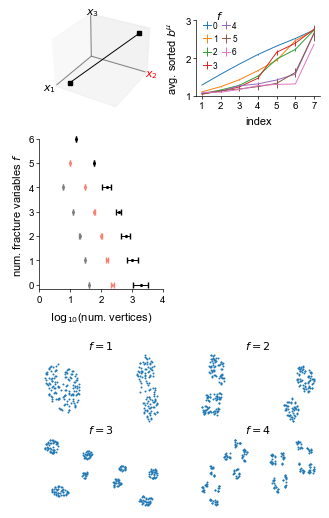

In [15]:
axes = make_axes()
plot_vert_info(axes[2])
plot_mean_curves(axes[1])
plot_tsne(axes[-4:])
plot_schematic(axes[0])


#plt.savefig("../figs/convex_revised.pdf")

(360, 22)
(132, 22)
(60, 22)


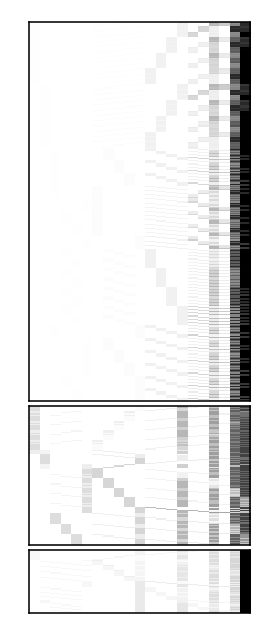

In [16]:
fig, axes = plt.subplots(
    3, 1, figsize=(1, 2.628),
    gridspec_kw={'height_ratios': [360, 132, 60]})
fig.subplots_adjust(hspace=0.025, left=0, right=1, top=1, bottom=0)
plot_barcode(f=3, ax=axes[0])
plot_barcode(f=4, ax=axes[1])
plot_barcode(f=5, ax=axes[2])
#plt.savefig("../figs/barcodes.pdf", dpi=450)